# NLP Standard Project - Identifying Human Values behind Arguments

*Objective*: given a textual argument and a human value category, classify whether or not the argument draws on that category.

Arguments are given as premise text, conclusion text, and binary
stance of the premise to the conclusion (“in favor of” or “against”). 20 value categories compiled from the social science literature. It’s your choice to focus on one, a subset, or all values in arguments.

## Imports

*N.B.* `zenodo-get` is a Python package that provides a simple way to download data from the Zenodo reository. 

In [1]:
!pip install transformers
!pip install evaluate
!pip install zenodo-get
!zenodo_get 10.5281/zenodo.7550385

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.2 MB/s eta 0:00:00

In [2]:
#shutil.rmtree('bert-base-uncased')

In [3]:
import evaluate, torch, shutil, random, re, nltk, transformers
import pandas as pd
import numpy as np
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from functools import reduce
from transformers import AutoTokenizer, AutoModelForSequenceClassification, EvalPrediction, TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import Dataset, DatasetDict, load_dataset
from typing import List, Callable
from sklearn.metrics import f1_score, precision_score, recall_score

We set a random seed to repeat experiments.

In [4]:
random_seed = 42
transformers.set_seed(random_seed)
torch.manual_seed(random_seed)

We check whether a GPU is available on the system and, if so, we run the code on the GPU by assigning `cuda` to the device variable; otherwise, we assign `cpu`.



In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Arranging the Data

Once the data have been downloaded from the Zenodo repository, we merge the arguments and their respective labels into a single dataset. We do this for both training and test set.

*N.B.* The test set has not been labelled so we adopt the validation set as test one.

In [6]:
arguments_train_path = 'arguments-training.tsv'
arguments_val_path = 'arguments-validation.tsv'
arguments_test_path = 'arguments-validation-zhihu.tsv'

labels_train_path = 'labels-training.tsv'
labels_val_path = 'labels-validation.tsv'
labels_test_path = 'labels-validation-zhihu.tsv'

In [7]:
df_arguments_train = pd.read_csv(arguments_train_path, sep='\t')
df_labels_train = pd.read_csv(labels_train_path, sep='\t')
df_train = pd.merge(df_arguments_train, df_labels_train, on='Argument ID')

df_arguments_val = pd.read_csv(arguments_val_path, sep='\t')
df_labels_val = pd.read_csv(labels_val_path, sep='\t')
df_val = pd.merge(df_arguments_val, df_labels_val, on='Argument ID')

df_arguments_test = pd.read_csv(arguments_test_path, sep='\t')
df_labels_test = pd.read_csv(labels_test_path, sep='\t')
df_test = pd.merge(df_arguments_test, df_labels_test, on='Argument ID')

In [8]:
df_train.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [9]:
df_val.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01001,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01012,The use of public defenders should be mandatory,in favor of,the use of public defenders should be mandator...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,A02001,Payday loans should be banned,in favor of,payday loans create a more impoverished societ...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,A02002,Surrogacy should be banned,against,Surrogacy should not be banned as it is the wo...,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A02009,Entrapment should be legalized,against,entrapment is gravely immoral and against huma...,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1


In [10]:
df_test.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,C26001,We should abolish the 996 overtime system,in favor of,China's 996 overtime system is very inefficien...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,C26002,We should abolish the 996 overtime system,in favor of,China's 996 overtime system leaves you with no...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,C26003,We should abolish the 996 overtime system,against,"For the poor people, if they can go to the Int...",0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,C26004,We should abolish the 996 overtime system,in favor of,China's 996 overtime system violates labor laws.,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,C26005,We should abolish the 996 overtime system,against,Corporate management seeks to maximize profits...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Exploring the Data

In [11]:
# check the distribution of the data
print("Shape of the Training Dataset: ", df_train.shape)
print()
print("Shape of the Validation Dataset: ", df_val.shape)
print()
print("Shape of the Test Dataset: ", df_test.shape)
print()

Shape of the Training Dataset:  (5393, 24)

Shape of the Validation Dataset:  (1896, 24)

Shape of the Test Dataset:  (100, 24)



In [12]:
columns = df_train.columns.tolist()

print("Distribution of the classes for the training set: ")
print()
for c in columns[4:]:
  print(df_train[c].value_counts())
  print()

Distribution of the classes for the training set: 

0    4405
1     988
Name: Self-direction: thought, dtype: int64

0    3998
1    1395
Name: Self-direction: action, dtype: int64

0    5146
1     247
Name: Stimulation, dtype: int64

0    5221
1     172
Name: Hedonism, dtype: int64

0    3881
1    1512
Name: Achievement, dtype: int64

0    4783
1     610
Name: Power: dominance, dtype: int64

0    4768
1     625
Name: Power: resources, dtype: int64

0    5011
1     382
Name: Face, dtype: int64

0    3393
1    2000
Name: Security: personal, dtype: int64

0    3665
1    1728
Name: Security: societal, dtype: int64

0    4825
1     568
Name: Tradition, dtype: int64

0    4216
1    1177
Name: Conformity: rules, dtype: int64

0    5186
1     207
Name: Conformity: interpersonal, dtype: int64

0    4998
1     395
Name: Humility, dtype: int64

0    4061
1    1332
Name: Benevolence: caring, dtype: int64

0    4587
1     806
Name: Benevolence: dependability, dtype: int64

0    3312
1    2081
Name:

In [13]:
print("Distribution of the classes for the validation set: ")
print()
for c in columns[4:]:
  print(df_val[c].value_counts())
  print()

Distribution of the classes for the validation set: 

0    1645
1     251
Name: Self-direction: thought, dtype: int64

0    1400
1     496
Name: Self-direction: action, dtype: int64

0    1758
1     138
Name: Stimulation, dtype: int64

0    1793
1     103
Name: Hedonism, dtype: int64

0    1321
1     575
Name: Achievement, dtype: int64

0    1732
1     164
Name: Power: dominance, dtype: int64

0    1764
1     132
Name: Power: resources, dtype: int64

0    1766
1     130
Name: Face, dtype: int64

0    1137
1     759
Name: Security: personal, dtype: int64

0    1408
1     488
Name: Security: societal, dtype: int64

0    1724
1     172
Name: Tradition, dtype: int64

0    1441
1     455
Name: Conformity: rules, dtype: int64

0    1836
1      60
Name: Conformity: interpersonal, dtype: int64

0    1769
1     127
Name: Humility, dtype: int64

0    1263
1     633
Name: Benevolence: caring, dtype: int64

0    1628
1     268
Name: Benevolence: dependability, dtype: int64

0    1209
1     687
Nam

In [14]:
print("Distribution of the classes for the test set: ")
print()
for c in columns[4:]:
  print(df_test[c].value_counts())
  print()

Distribution of the classes for the test set: 

0    94
1     6
Name: Self-direction: thought, dtype: int64

0    89
1    11
Name: Self-direction: action, dtype: int64

0    100
Name: Stimulation, dtype: int64

0    98
1     2
Name: Hedonism, dtype: int64

0    61
1    39
Name: Achievement, dtype: int64

0    99
1     1
Name: Power: dominance, dtype: int64

0    81
1    19
Name: Power: resources, dtype: int64

0    99
1     1
Name: Face, dtype: int64

0    70
1    30
Name: Security: personal, dtype: int64

0    69
1    31
Name: Security: societal, dtype: int64

0    100
Name: Tradition, dtype: int64

0    85
1    15
Name: Conformity: rules, dtype: int64

0    99
1     1
Name: Conformity: interpersonal, dtype: int64

0    95
1     5
Name: Humility, dtype: int64

0    88
1    12
Name: Benevolence: caring, dtype: int64

0    97
1     3
Name: Benevolence: dependability, dtype: int64

0    79
1    21
Name: Universalism: concern, dtype: int64

0    92
1     8
Name: Universalism: nature, dtyp

Training set labels distribution


<Figure size 1500x1000 with 0 Axes>

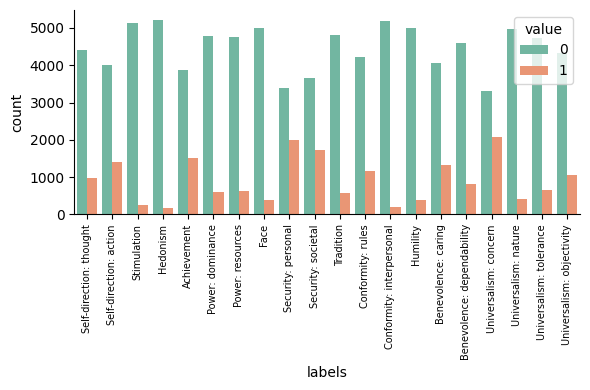

In [15]:
print("Training set labels distribution")
plt.figure(figsize=(15,10))

# create a DataFrame with all the columns to be plotted
plot_data = pd.melt(df_train[columns[4:]], var_name='labels')

# plot the data with catplot
g = sns.catplot(data=plot_data, 
                x='labels', 
                hue='value', 
                kind='count', 
                height=4, 
                aspect=1.5, 
                palette='Set2', 
                legend_out=False)

# rotate the x-axis tick labels and set the font size
g.set_xticklabels(rotation=90, fontsize=7)

plt.tight_layout()
plt.show()

Validation set labels distribution


<Figure size 1500x1000 with 0 Axes>

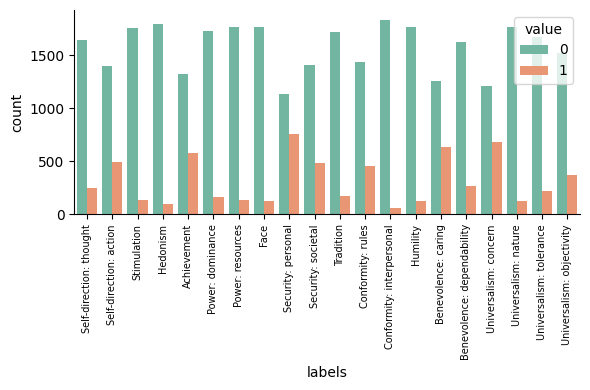

In [16]:
print("Validation set labels distribution")
plt.figure(figsize=(15,10))

# create a DataFrame with all the columns to be plotted
plot_data = pd.melt(df_val[columns[4:]], var_name='labels')

# plot the data with catplot
g = sns.catplot(data=plot_data, 
                x='labels', 
                hue='value', 
                kind='count', 
                height=4, 
                aspect=1.5, 
                palette='Set2', 
                legend_out=False)

# rotate the x-axis tick labels and set the font size
g.set_xticklabels(rotation=90, fontsize=7)

plt.tight_layout()
plt.show()

Test set labels distribution


<Figure size 1500x1000 with 0 Axes>

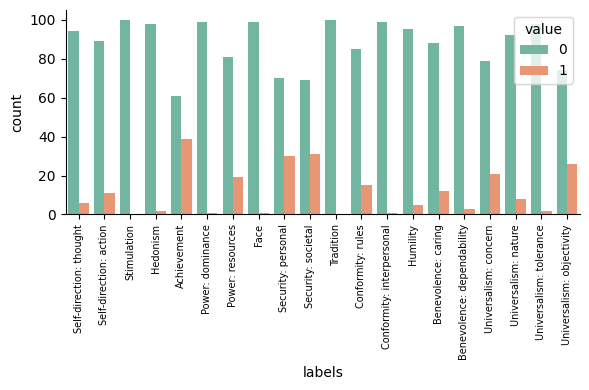

In [17]:
print("Test set labels distribution")
plt.figure(figsize=(15,10))

# create a DataFrame with all the columns to be plotted
plot_data = pd.melt(df_test[columns[4:]], var_name='labels')

# plot the data with catplot
g = sns.catplot(data=plot_data, 
                x='labels', 
                hue='value', 
                kind='count', 
                height=4, 
                aspect=1.5, 
                palette='Set2', 
                legend_out=False)

# rotate the x-axis tick labels and set the font size
g.set_xticklabels(rotation=90, fontsize=7)

plt.tight_layout()
plt.show()

## Preprocessing the Data

In [18]:
replace_by_space_re = re.compile('[/(){}\[\]\|@,;]')
good_symbols_re = re.compile('[^0-9a-z #+_]')
replace_multiple_spaces_re = re.compile(' +')
good_stopwords = ['favor','against']

try:
    stopwords = set(stopwords.words('english'))
    print(stopwords)
    stopwords = stopwords - set(good_stopwords) # removing word: against and favor from stopwords
    print(stopwords)
except LookupError:
    nltk.download('stopwords')
    stopwords = set(stopwords.words('english'))
    stopwords = stopwords - set(good_stopwords) # removing word: against and favor from stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    """
    return text.lower()
 
def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis, with spacing character
    """
    return replace_by_space_re.sub(' ', text)

def replace_br(text: str) -> str:
    """
    Replaces br characters
    """
    return text.replace('br', '')

def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the good symbols list (check regular expression)
    """
    return good_symbols_re.sub('', text)
 
def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in stopwords])
 
def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from text.
    """
    return text.strip()

def replace_double_spaces(text: str) -> str:
    """
    Replaces special characters, such as paranthesis, with spacing character
    """
    return replace_multiple_spaces_re.sub(' ', text)

In [20]:
preprocessing_pipeline = [
                          lower,
                          replace_special_characters,
                          replace_br,
                          filter_out_uncommon_symbols,
                          remove_stopwords,
                          strip_text,
                          replace_double_spaces
                          ]

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """
    filter_methods = filter_methods if filter_methods is not None else preprocessing_pipeline
    return reduce(lambda txt, f: f(txt), filter_methods, text)

In [21]:
# Replace each sentence with its pre-processed version
df_train['Conclusion'] = df_train['Conclusion'].apply(lambda txt: text_prepare(txt))
df_train['Stance'] = df_train['Stance'].apply(lambda txt: text_prepare(txt))
df_train['Premise'] = df_train['Premise'].apply(lambda txt: text_prepare(txt))

df_val['Conclusion'] = df_val['Conclusion'].apply(lambda txt: text_prepare(txt))
df_val['Stance'] = df_val['Stance'].apply(lambda txt: text_prepare(txt))
df_val['Premise'] = df_val['Premise'].apply(lambda txt: text_prepare(txt))

df_test['Conclusion'] = df_test['Conclusion'].apply(lambda txt: text_prepare(txt))
df_test['Stance'] = df_test['Stance'].apply(lambda txt: text_prepare(txt))
df_test['Premise'] = df_test['Premise'].apply(lambda txt: text_prepare(txt))

In [22]:
df_train.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,ban human cloning,favor,ban human cloning cause huge issues bunch huma...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,ban fast food,favor,fast food banned really bad health costly,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A01006,end use economic sanctions,against,sometimes economic sanctions thing get corrupt...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,A01007,abolish capital punishment,against,capital punishment sometimes option keep crimi...,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A01008,ban factory farming,against,factory farming allows production cheap food n...,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [23]:
df_val.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01001,entrapment legalized,favor,entrapment serve easily capture wanted crimina...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01012,use public defenders mandatory,favor,use public defenders mandatory people dont mon...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,A02001,payday loans banned,favor,payday loans create impoverished society crazy...,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,A02002,surrogacy banned,against,surrogacy banned womans right choose wishes an...,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,A02009,entrapment legalized,against,entrapment gravely immoral against human right...,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1


In [24]:
df_test.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,C26001,abolish 996 overtime system,favor,chinas 996 overtime system inefficient enhanci...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,C26002,abolish 996 overtime system,favor,chinas 996 overtime system leaves room learn i...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,C26003,abolish 996 overtime system,against,poor people go internet factory chinas 996 ove...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,C26004,abolish 996 overtime system,favor,chinas 996 overtime system violates labor laws,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,C26005,abolish 996 overtime system,against,corporate management seeks maximize profits ch...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Tokenization

In [25]:
max_length = 94

In [26]:
model_name = "bert-base-uncased" #"distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, truncation=True, padding=True, max_length=max_length)
#add_special_tokens=False
#use_auth_token=True

## Define evaluation metrics

In [27]:
"""
def tokenize_and_encode(samples):
    #Tokenizes each arguments "Premise"
    print(samples)
    return tokenizer(samples['Premise'], truncation=True)
"""

def tokenize_and_encode(samples):   # max_len = 512
    """Tokenizes each arguments "Premise" """
    #print(type(samples))
    #print(samples.get('Premise'))
    input_list = [samples.get(key) for key in ['Conclusion', 'Stance', 'Premise']]
    #print(input_list)
    input = ' '.join(input_list)
    #print(input)
    return tokenizer(input) #add_special_tokens=False


def convert_to_dataset(train_dataframe, val_dataframe, test_dataframe, columns):
    """
        Converts pandas DataFrames into a DatasetDict

        Parameters
        ----------
        train_dataframe : pd.DataFrame
            Arguments to be listed as "train"
        test_dataframe : pd.DataFrame
            Arguments to be listed as "test"
        columns : list[str]
            The labels in both DataFrames

        Returns
        -------
        tuple(DatasetDict, list[str])
            a `DatasetDict` with attributes "train" and "test" for the listed arguments,
            a `list` with the contained labels
        """
#    column_intersect = [x for x in (['Premise'] + labels) if x in train_dataframe.columns.values]

    train_dataset = Dataset.from_dict((train_dataframe[columns]).to_dict('list'))
    val_dataset = Dataset.from_dict((val_dataframe[columns]).to_dict('list'))
    test_dataset = Dataset.from_dict((test_dataframe[columns]).to_dict('list')) 

    ds = DatasetDict()
    ds['train'] = train_dataset
    ds['eval'] = val_dataset
    ds['test'] = test_dataset

    ds = ds.map(lambda x: {"labels": [float(x[c]) for c in columns[4:]]}) # put the one hot encoded row as a list in labels

    ds_enc = ds.map(tokenize_and_encode, remove_columns=columns) #remove the header of the columns   
    
    return ds_enc, columns[4:]

In [28]:
ds_enc, labels = convert_to_dataset(df_train, df_val, df_test, columns)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [29]:
ds_enc # dataset formattato da dare input al modello

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5393
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1896
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 100
    })
})

In [30]:
# Computing the max length of the token
length = []
for i in range(0,len(ds_enc["train"])):
  length.append(len(ds_enc["train"][i]["input_ids"]))

print("ARGMAX:",np.argmax(length))
print("ARGMIN:",np.argmin(length))
max_length =np.max(length)
print(max_length)

ARGMAX: 4758
ARGMIN: 3208
92


## Training of the model

In [31]:
ds_enc["train"].format

{'type': None,
 'format_kwargs': {},
 'columns': ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
 'output_all_columns': False}

In [32]:
#ds_enc.set_format("torch")
print(type(ds_enc["train"][0]["input_ids"]))


print(len(ds_enc["train"][0]["input_ids"]))
print(ds_enc["train"][0]["input_ids"])
print(tokenizer.decode(ds_enc["train"][0]["input_ids"]))
print(tokenizer.decode(ds_enc["train"][0]["input_ids"]))
print(len(ds_enc["train"]))

<class 'list'>
19
[101, 7221, 2529, 18856, 13369, 5684, 7221, 2529, 18856, 13369, 3426, 4121, 3314, 9129, 4286, 2770, 2105, 3772, 102]
[CLS] ban human cloning favor ban human cloning cause huge issues bunch humans running around acting [SEP]
[CLS] ban human cloning favor ban human cloning cause huge issues bunch humans running around acting [SEP]
5393


In [33]:
ds_enc["train"].format

{'type': None,
 'format_kwargs': {},
 'columns': ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
 'output_all_columns': False}

In [34]:
num_labels = len(labels)

## MODEL

In [35]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=num_labels
                                                           )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [36]:
model = model.to(device)

In [37]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [38]:
batch_size_train = 128 # max dimension : 128
batch_size_eval = 128

In [39]:
'''
# VERSIONE 1
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    
    # Apply a threshold of 0.5 to the predicted labels to obtain binary predictions
    binary_pred_labels = np.where(preds > 0.5, 1, 0)
    
    # Get the list of target names from the label encoder
    target_names = p.label_ids.dtype.names
    
    # Generate a classification report
    report = classification_report(p.label_ids, binary_pred_labels, target_names=target_names, zero_division=1)
    
    return {"classification_report": report}
'''

'\n# VERSIONE 1\ndef compute_metrics(p: EvalPrediction):\n    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions\n    \n    # Apply a threshold of 0.5 to the predicted labels to obtain binary predictions\n    binary_pred_labels = np.where(preds > 0.5, 1, 0)\n    \n    # Get the list of target names from the label encoder\n    target_names = p.label_ids.dtype.names\n    \n    # Generate a classification report\n    report = classification_report(p.label_ids, binary_pred_labels, target_names=target_names, zero_division=1)\n    \n    return {"classification_report": report}\n'

In [40]:
'''
# VERSIONE 2
def compute_metrics(p: EvalPrediction):
    
    #EvalPrediction
    #predictions (np.ndarray) — Predictions of the model.
    #label_ids (np.ndarray) — Targets to be matched.
    #inputs (np.ndarray, optional) —
    
    print("inputs: \n", p.inputs)
    print("label_ids: \n", p.label_ids)
    print("predictions: \n", p.predictions)
    print("type_inputs: \n", type(p.inputs))
    print("type_label_ids: \n", type(p.label_ids))
    print("type_predictions: \n", type(p.predictions))
   


    predictions = F.softmax(p.predictions, dim=1)
    print('predictions: \n', predictions)
    # Apply a threshold of 0.2 to the predicted labels to obtain binary predictions
    threshold = 0.2
    predictions = (probabilities > threshold).float()
    predictions = torch.where(predictions == 1.0)
    predictions = predictions[1].tolist()

    # Get the list of target names from the label encoder
    #target_names = p.label_ids.dtype.names
    
    # Generate a classification report
    report = classification_report(y_true=p.label_ids, y_pred=predictions, target_names=labels, zero_division=0)
    
    return {"classification_report": report}
  '''

'\n# VERSIONE 2\ndef compute_metrics(p: EvalPrediction):\n    \n    #EvalPrediction\n    #predictions (np.ndarray) — Predictions of the model.\n    #label_ids (np.ndarray) — Targets to be matched.\n    #inputs (np.ndarray, optional) —\n    \n    print("inputs: \n", p.inputs)\n    print("label_ids: \n", p.label_ids)\n    print("predictions: \n", p.predictions)\n    print("type_inputs: \n", type(p.inputs))\n    print("type_label_ids: \n", type(p.label_ids))\n    print("type_predictions: \n", type(p.predictions))\n   \n\n\n    predictions = F.softmax(p.predictions, dim=1)\n    print(\'predictions: \n\', predictions)\n    # Apply a threshold of 0.2 to the predicted labels to obtain binary predictions\n    threshold = 0.2\n    predictions = (probabilities > threshold).float()\n    predictions = torch.where(predictions == 1.0)\n    predictions = predictions[1].tolist()\n\n    # Get the list of target names from the label encoder\n    #target_names = p.label_ids.dtype.names\n    \n    # Gener

In [41]:
id2label = {
 0:'Self-direction: thought',
 1:'Self-direction: action',
 2:'Stimulation',
 3:'Hedonism',
 4:'Achievement',
 5:'Power: dominance',
 6:'Power: resources',
 7:'Face',
 8:'Security: personal',
 9:'Security: societal',
 10:'Tradition',
 11:'Conformity: rules',
 12:'Conformity: interpersonal',
 13:'Humility',
 14:'Benevolence: caring',
 15:'Benevolence: dependability',
 16:'Universalism: concern',
 17:'Universalism: nature',
 18:'Universalism: tolerance',
 19:'Universalism: objectivity'}

In [42]:
'''
# VERSIONE 3 - NOTEBBOK ASSIGNMENT 2
    #EvalPrediction
    #predictions (np.ndarray) — Predictions of the model.
    #label_ids (np.ndarray) — Targets to be matched.
    #inputs (np.ndarray, optional) —
def compute_metrics(pred: EvalPrediction):
  print(pred)
  print(type(pred))
  # Get the ground truth labels and predicted labels
  targets = pred.label_ids #TARGETS 
  predictions = pred.predictions #predizioni
  
  # Convert predictions to a PyTorch tensor
  predictions = torch.tensor(predictions)

  ###
  probabilities = F.sigmoid(predictions)

  threshold = 0.5

  predictions = (probabilities > threshold).float()

  predictions = torch.where(predictions == 1.0)
  #trasform in a list of indeces
  predictions = predictions[1].tolist()
  predictions = [id2label[idx] for idx in predictions]

  ###
  report = classification_report(y_true=targets, y_pred=predictions, target_names=labels, zero_division=0)
  
  return {"classification_report": report}
  '''

'\n# VERSIONE 3 - NOTEBBOK ASSIGNMENT 2\n    #EvalPrediction\n    #predictions (np.ndarray) — Predictions of the model.\n    #label_ids (np.ndarray) — Targets to be matched.\n    #inputs (np.ndarray, optional) —\ndef compute_metrics(pred: EvalPrediction):\n  print(pred)\n  print(type(pred))\n  # Get the ground truth labels and predicted labels\n  targets = pred.label_ids #TARGETS \n  predictions = pred.predictions #predizioni\n  \n  # Convert predictions to a PyTorch tensor\n  predictions = torch.tensor(predictions)\n\n  ###\n  probabilities = F.sigmoid(predictions)\n\n  threshold = 0.5\n\n  predictions = (probabilities > threshold).float()\n\n  predictions = torch.where(predictions == 1.0)\n  #trasform in a list of indeces\n  predictions = predictions[1].tolist()\n  predictions = [id2label[idx] for idx in predictions]\n\n  ###\n  report = classification_report(y_true=targets, y_pred=predictions, target_names=labels, zero_division=0)\n  \n  return {"classification_report": report}\n  '

In [43]:
def f1_score_per_label(y_pred, y_true, value_classes, thresh=0.5, sigmoid=True):
    """Compute label-wise and averaged F1-scores"""
    y_pred = torch.from_numpy(y_pred)
    y_true = torch.from_numpy(y_true)
    if sigmoid:
        y_pred = y_pred.sigmoid()

    y_true = y_true.bool().numpy()
    y_pred = (y_pred > thresh).numpy()

    f1_scores = {}
    precision_scores ={}
    recall_scores ={}
    for i, v in enumerate(value_classes):
        f1_scores[v] = round(f1_score(y_true[:, i], y_pred[:, i], zero_division=0), 2)
        precision_scores[v] = round(precision_score(y_true[:, i], y_pred[:, i], zero_division=0), 2)
        recall_scores[v] = round(recall_score(y_true[:, i], y_pred[:, i], zero_division=0), 2)

    f1_scores['avg-f1-score'] = round(np.mean(list(f1_scores.values())), 2)
    precision_scores['avg-precision-score'] = round(np.mean(list(precision_scores.values())), 2)
    recall_scores['avg-recall-score'] = round(np.mean(list(recall_scores.values())), 2)



    return f1_scores, precision_scores, recall_scores

In [44]:
def compute_metrics(eval_pred, value_classes):
    """Custom metric calculation function for MultiLabelTrainer"""
    predictions, labels = eval_pred
    f1scores,precision_scores,recall_scores=f1_score_per_label(predictions, labels, value_classes)
    return {#'accuracy_thresh': accuracy_thresh(predictions, labels),
            'f1-score': f1scores,
            'macro-avg-f1score': f1scores['avg-f1-score'],
            'precision-score': precision_scores,
            'macro-avg-precision-score': precision_scores['avg-precision-score'],
            'recall-score': recall_scores,
            'macro-avg-recall-score': recall_scores['avg-recall-score']}

In [45]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience = 3, # number of times to wait without improvement before stopping
    early_stopping_threshold = 0.001 # minimum improvement required to count as improvement
)

In [46]:
args = TrainingArguments(
                         model_name,
                         evaluation_strategy = "epoch",
                         save_strategy = "epoch", # parametro attivato per EarlyStopping
                         logging_strategy='epoch',
                         #logging_steps = 100,
                         learning_rate=2e-5, #1e-5
                         per_device_train_batch_size=batch_size_train,
                         per_device_eval_batch_size=batch_size_eval,
                         num_train_epochs=20,
                         weight_decay=0.1, #0.01
                         load_best_model_at_end=True, # flag attivato per EarlyStopping
                         seed=42,
                         #push_to_hub=True,
                         )

The main difference between nn.CrossEntropyLoss() and nn.BCEWithLogitsLoss() for multi-label classification tasks is in their assumptions about the label encoding.

nn.CrossEntropyLoss() assumes that the labels are encoded as class indices, where each sample is associated with a single class. This means that for multi-label classification tasks, the labels need to be one-hot encoded, which can be memory-intensive and computationally expensive for large datasets with a large number of classes. Additionally, nn.CrossEntropyLoss() applies a softmax activation function to the output layer of the neural network, which can cause numerical instability and saturation when dealing with a large number of classes.

nn.BCEWithLogitsLoss(), on the other hand, assumes that the labels are encoded as binary indicators, where each sample can be associated with multiple classes. This means that the labels can be encoded as a tensor of binary values, where each element corresponds to a different class. The BCE stands for binary cross-entropy, and the WithLogits means that the function expects the output of the neural network to be unnormalized logits, rather than probabilities.

In summary, nn.CrossEntropyLoss() is appropriate for multi-class classification tasks, where each sample belongs to one and only one class, and the labels are one-hot encoded. nn.BCEWithLogitsLoss() is appropriate for multi-label classification tasks, where each sample can belong to multiple classes, and the labels are binary encoded.

In [47]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss = torch.nn.BCEWithLogitsLoss()(logits,labels)
        #loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [48]:
trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=ds_enc["train"],
    eval_dataset=ds_enc["eval"],
    tokenizer=tokenizer,
    compute_metrics=lambda x: compute_metrics(x, labels),
    callbacks=[early_stopping_callback]  # add the early stopping callback
)

In [49]:
trainer

In [50]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1-score,Macro-avg-f1score,Precision-score,Macro-avg-precision-score,Recall-score,Macro-avg-recall-score
1,0.526100,0.435099,"{'Self-direction: thought': 0.0, 'Self-direction: action': 0.0, 'Stimulation': 0.0, 'Hedonism': 0.0, 'Achievement': 0.0, 'Power: dominance': 0.0, 'Power: resources': 0.0, 'Face': 0.0, 'Security: personal': 0.0, 'Security: societal': 0.0, 'Tradition': 0.0, 'Conformity: rules': 0.0, 'Conformity: interpersonal': 0.0, 'Humility': 0.0, 'Benevolence: caring': 0.0, 'Benevolence: dependability': 0.0, 'Universalism: concern': 0.0, 'Universalism: nature': 0.0, 'Universalism: tolerance': 0.0, 'Universalism: objectivity': 0.0, 'avg-f1-score': 0.0}",0.000000,"{'Self-direction: thought': 0.0, 'Self-direction: action': 0.0, 'Stimulation': 0.0, 'Hedonism': 0.0, 'Achievement': 0.0, 'Power: dominance': 0.0, 'Power: resources': 0.0, 'Face': 0.0, 'Security: personal': 0.0, 'Security: societal': 0.0, 'Tradition': 0.0, 'Conformity: rules': 0.0, 'Conformity: interpersonal': 0.0, 'Humility': 0.0, 'Benevolence: caring': 0.0, 'Benevolence: dependability': 0.0, 'Universalism: concern': 0.0, 'Universalism: nature': 0.0, 'Universalism: tolerance': 0.0, 'Universalism: objectivity': 0.0, 'avg-precision-score': 0.0}",0.000000,"{'Self-direction: thought': 0.0, 'Self-direction: action': 0.0, 'Stimulation': 0.0, 'Hedonism': 0.0, 'Achievement': 0.0, 'Power: dominance': 0.0, 'Power: resources': 0.0, 'Face': 0.0, 'Security: personal': 0.0, 'Security: societal': 0.0, 'Tradition': 0.0, 'Conformity: rules': 0.0, 'Conformity: interpersonal': 0.0, 'Humility': 0.0, 'Benevolence: caring': 0.0, 'Benevolence: dependability': 0.0, 'Universalism: concern': 0.0, 'Universalism: nature': 0.0, 'Universalism: tolerance': 0.0, 'Universalism: objectivity': 0.0, 'avg-recall-score': 0.0}",0.000000


Trainer is attempting to log a value of "{'Self-direction: thought': 0.0, 'Self-direction: action': 0.0, 'Stimulation': 0.0, 'Hedonism': 0.0, 'Achievement': 0.0, 'Power: dominance': 0.0, 'Power: resources': 0.0, 'Face': 0.0, 'Security: personal': 0.0, 'Security: societal': 0.0, 'Tradition': 0.0, 'Conformity: rules': 0.0, 'Conformity: interpersonal': 0.0, 'Humility': 0.0, 'Benevolence: caring': 0.0, 'Benevolence: dependability': 0.0, 'Universalism: concern': 0.0, 'Universalism: nature': 0.0, 'Universalism: tolerance': 0.0, 'Universalism: objectivity': 0.0, 'avg-f1-score': 0.0}" of type <class 'dict'> for key "eval/f1-score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'Self-direction: thought': 0.0, 'Self-direction: action': 0.0, 'Stimulation': 0.0, 'Hedonism': 0.0, 'Achievement': 0.0, 'Power: dominance': 0.0, 'Power: resources': 0.0, 'Face': 0.0, 'Security: personal': 0.0, 'Securit

KeyboardInterrupt: ignored

In [ ]:
print(ds_enc['train']['labels'][2])

The values of "0.00" in the classification report indicate that the model did not predict any positive examples for those particular classes. In other words, the precision, recall, and F1-score for those classes are all zero because there were no true positives or false positives predicted by the model. This can happen for a variety of reasons, such as a lack of training data for those classes or a lack of predictive power for the features associated with those classes. It's important to consider why the model is failing to predict positive examples for certain classes and whether additional data or feature engineering could improve performance on those classes.

## Evaluation

Runs are evaluated on the basis of F1-score, Precision, and Recall in TIRA: averaged over all value categories and for each category individually. For the shared task leaderboard, the runs are ranked according to the averaged F1-score on the "arguments-test" dataset, corresponding to the arguments-test.tsv of the dataset.

eval precision recall f1-score


test f1

In [ ]:
trainer.evaluate()

## Inference

In [ ]:
print((ds_enc['train']['input_ids'][2]))
print(tokenizer.decode(ds_enc['train']['input_ids'][2]))

In [ ]:
id2label = {
 0:'Self-direction: thought',
 1:'Self-direction: action',
 2:'Stimulation',
 3:'Hedonism',
 4:'Achievement',
 5:'Power: dominance',
 6:'Power: resources',
 7:'Face',
 8:'Security: personal',
 9:'Security: societal',
 10:'Tradition',
 11:'Conformity: rules',
 12:'Conformity: interpersonal',
 13:'Humility',
 14:'Benevolence: caring',
 15:'Benevolence: dependability',
 16:'Universalism: concern',
 17:'Universalism: nature',
 18:'Universalism: tolerance',
 19:'Universalism: objectivity'}

In [ ]:
example = random.randint(1,100)
print("Number example:", example)


device = torch.device("cuda")
print(len(ds_enc['test']))
text = tokenizer.decode(ds_enc['test']['input_ids'][example])
print("Input text:\n", text)
inputs = tokenizer(text, return_tensors = 'pt')
for key in inputs:
    inputs[key] = inputs[key].to(device)

with torch.no_grad():
  outputs = model(inputs['input_ids'])
  outputs = {key: output.cpu() for key, output in outputs.items()}


#probabilities_soft = F.softmax(outputs['logits'], dim=1)
probabilities = F.sigmoid(outputs['logits'])

#print("softmax \n",probabilities_soft)
print("sigmoid \n", probabilities)


threshold = 0.5
predictions = (probabilities > threshold).float()

pred_labels = torch.where(predictions == 1.0)
#trasform in a list of indeces
pred_labels = pred_labels[1].tolist()
pred_labels = [id2label[idx] for idx in pred_labels]
print("The predicted labels are:\n", pred_labels)

true_labels = ds_enc['test']['labels'][example]
indexes = []
index = 0
for i in true_labels:
  if i == 1.0:
    indexes.append(index)
    index += 1
  else:
    index += 1
true_labels = [id2label[idx] for idx in indexes]
print("The actual labels are:\n", true_labels)

In [ ]:
'''
from sklearn.metrics import classification_report

def compute_metrics(p: EvalPrediction):
    
    #EvalPrediction
    #predictions (np.ndarray) — Predictions of the model.
    #label_ids (np.ndarray) — Targets to be matched.
    #inputs (np.ndarray, optional) —
    
    print("inputs: \n", p.inputs)
    print("label_ids: \n", p.label_ids)
    print("predictions: \n", p.predictions)
    print("type_inputs: \n", type(p.inputs))
    print("type_label_ids: \n", type(p.label_ids))
    print("type_predictions: \n", type(p.predictions))
   


    predictions = F.softmax(p.predictions, dim=1)
    print('predictions: \n', predictions)
    # Apply a threshold of 0.2 to the predicted labels to obtain binary predictions
    threshold = 0.2
    predictions = (probabilities > threshold).float()
    predictions = torch.where(predictions == 1.0)
    predictions = predictions[1].tolist()

    # Get the list of target names from the label encoder
    #target_names = p.label_ids.dtype.names
    
    # Generate a classification report
    report = classification_report(y_true=p.label_ids, y_pred=predictions, target_names=labels, zero_division=0)
    
    return {"classification_report": report}
'''